<a href="https://colab.research.google.com/github/bernarducs/caged_time_series/blob/master/Estudo_estoques_formais_BAHIA_SERVI%C3%87OS_SARIMA_com_grid_search_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objetivo
### Abaixo, utilizaremos funções que buscarão os melhores parâmetros para modelagem do método ARIMA com fator sazonal - SARIMA.

Based on article: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

## Pacotes

In [7]:
from math import sqrt
from itertools import product
import pandas as pd

In [8]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [9]:
# multiprocessing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

In [10]:
# stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

## Datasets

In [11]:
# df = pd.read_csv("https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/traffic.txt", names=['col'])
# df.index = pd.date_range(start='1/1/2016', freq="D", periods=len(df))

#### Estoques

In [12]:
file_path = "/content/drive/My Drive/Colab Notebooks/emprego/bases/estoque_ba_servicos.xlsx"
df = pd.read_excel(file_path, index_col='ano_mes')
df.columns = ['estoques']
df.index = pd.to_datetime(df.index, format="%Y%m")
df.tail()

,estoques
ano_mes,
2020-03-01,791969
2020-04-01,776007
2020-05-01,769498
2020-06-01,768440
2020-07-01,768146


#### Saldo

In [13]:
file_path2 = "/content/drive/My Drive/Colab Notebooks/emprego/bases/saldo_caged_servicos_ba.xlsx"
df_saldo = pd.read_excel(file_path2)
df_saldo.columns = ['ano', 'saldo']
df_saldo.set_index('ano', inplace=True)
df_saldo.index = pd.to_datetime(df_saldo.index, format="%Y")
df_saldo.tail()

,saldo
ano,
2016-01-01,-30707
2017-01-01,2723
2018-01-01,22918
2019-01-01,10016
2020-01-01,-27487


## Rotinas

Aqui temos funções para o sarima em 1 passo (faz a predição para t+1). A próxima função é raiz quadrada dos erros médios e por fim a função responsável por separação do dataset entre teste e treino.

In [14]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, 
                 enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict()
	return yhat
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, percent_test=0.25):
  n_test = int(len(data) * percent_test)
  return data[:-n_test], data[-n_test:]

Aqui usamos a funções acima retornando o quadrado dos desvios.

In [15]:
# walk-forward validation for univariate data
def walk_forward_validation(data, percent_test, cfg):

  # split dataset
  train, test = train_test_split(data, percent_test)

  # fit model and make forecast for history
  yhat = sarima_forecast(train, cfg)

  # estimate prediction error
  error = measure_rmse(train, yhat)
  return error  

Avalia qual a melhor configuração de parâmetros `cfg` tem a melhor avaliação, ou seja, o menor erro.

In [16]:
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

In [17]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [18]:
# evaluating grid search results for test data
def test_grid_search_results(data, scores, ntop_scores=5):

  if ntop_scores > len(scores):
    ntop_scores = 5

  scores_test = list()
  _, test = train_test_split(data, percent_test=0.4)  

  for cfg_str, _ in scores[:ntop_scores]:
    cfg = eval(cfg_str)
    with catch_warnings():
      filterwarnings("ignore")
      yhat = sarima_forecast(test, cfg)
    error = measure_rmse(test, yhat)
    result = (cfg_str, error)
    print(result)
    scores_test.append(result)
  
  scores_test.sort(key=lambda tup: tup[1])
  return scores_test

In [19]:
def plot_model(data, cfg):
  order = cfg[0]
  s_order = cfg[1]
  trend = cfg[2]
  sarimax_pred = SARIMAX(
      endog=df, order=order, seasonal_order=s_order, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)

  model_sarimax_pred = sarimax_pred.fit(disp=False)

  previsao_sarimax = model_sarimax_pred.predict()

  error = measure_rmse(df, previsao_sarimax)
  print('Error:', error)

  plt.figure(figsize=(22, 10))
  plt.plot(previsao_sarimax[10:], label = 'forecast')
  plt.plot(df[10:], label = 'target')
  plt.title('Target x Forecast')
  plt.legend()
  plt.show()

In [20]:
def sarima_configs(seasonal=[12]):
  models = list()
  # define config lists
  p_params = [0, 1, 2]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n','c','t','ct']
  P_params = [0, 1, 2]
  D_params = [0, 1]
  Q_params = [0, 1]
  m_params = seasonal
  # create config instances
  for p, d, q, t, P, D, Q, m in product(p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    cfg = [(p,d,q), (P,D,Q,m), t]
    models.append(cfg)
  return models

## Gerando modelo

In [21]:
cfg_list = sarima_configs(seasonal=[12])
scores = grid_search(df, cfg_list, 0.25)

 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 767717.752
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 258783.491
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 100733467085.484
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 257957.255
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 258666.712
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'n']] 275445.446
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 257941.589
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'n']] 277674.426
 > Model[[(0, 0, 0), (2, 0, 0, 12), 'n']] 286577.441
 > Model[[(0, 0, 0), (2, 1, 0, 12), 'n']] 284055.895
 > Model[[(0, 0, 0), (2, 0, 1, 12), 'n']] 278138.591
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'c']] 81762.892
 > Model[[(0, 0, 0), (2, 1, 1, 12), 'n']] 346844.015
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'c']] 255316.534
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'c']] 85448.657
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'c']] 255023.612
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'c']] 264251.401
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'c']] 80818.539
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'c']] 7

In [22]:
scores[:3]

[("[(1, 0, 2), (1, 0, 1, 12), 'ct']", 72585.6586982647),
 ("[(1, 0, 2), (1, 0, 0, 12), 'ct']", 72585.70891291206),
 ("[(1, 0, 2), (1, 0, 0, 12), 'c']", 72587.28098845722)]

In [23]:
test_scores = test_grid_search_results(df, scores, ntop_scores=3)

("[(1, 0, 2), (1, 0, 1, 12), 'ct']", 3.960021620726898e+16)
("[(1, 0, 2), (1, 0, 0, 12), 'ct']", 114821.27681513193)
("[(1, 0, 2), (1, 0, 0, 12), 'c']", 114768.96402666475)


In [24]:
test_scores

[("[(1, 0, 2), (1, 0, 0, 12), 'c']", 114768.96402666475),
 ("[(1, 0, 2), (1, 0, 0, 12), 'ct']", 114821.27681513193),
 ("[(1, 0, 2), (1, 0, 1, 12), 'ct']", 3.960021620726898e+16)]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Error: 62895.08809058176


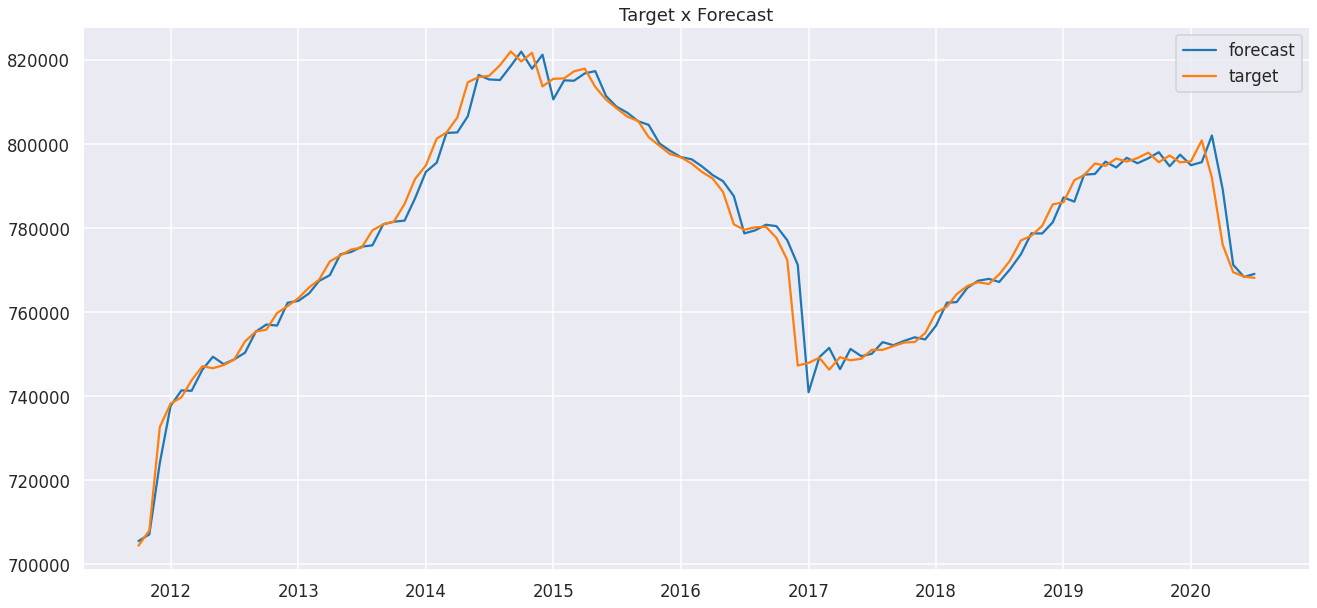

In [25]:
plot_model(df, eval(test_scores[0][0]))

___

## Previsão

In [26]:
cfg= eval(test_scores[0][0])
order = cfg[0]
s_order = cfg[1]
trend = cfg[2]
sarimax_pred = SARIMAX(
    endog=df, order=order, seasonal_order=s_order, trend=trend,
    enforce_stationarity=False, enforce_invertibility=False)

model_sarimax_pred = sarimax_pred.fit(disp=False)

fcast_sarimax = model_sarimax_pred.get_forecast(5)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [27]:
df_fcast = pd.concat([model_sarimax_pred.predict(), fcast_sarimax.predicted_mean], axis=0)

In [28]:
df_fcast.name = 'fcast'
df_fcast = pd.concat([df_fcast, fcast_sarimax.conf_int()], axis=1)
df_fcast.tail()

,fcast,lower estoques,upper estoques
2020-08-01,768710.971205,760151.516381,777270.426030
2020-09-01,769451.806832,755597.909771,783305.703894
2020-10-01,770192.207534,752300.639363,788083.775705
2020-11-01,770973.329525,750062.931103,791883.727947
2020-12-01,771658.829140,748328.779822,794988.878458


In [29]:
previsoes_sarimax = pd.concat(
    [df['estoques'], df_fcast],
    axis=1)

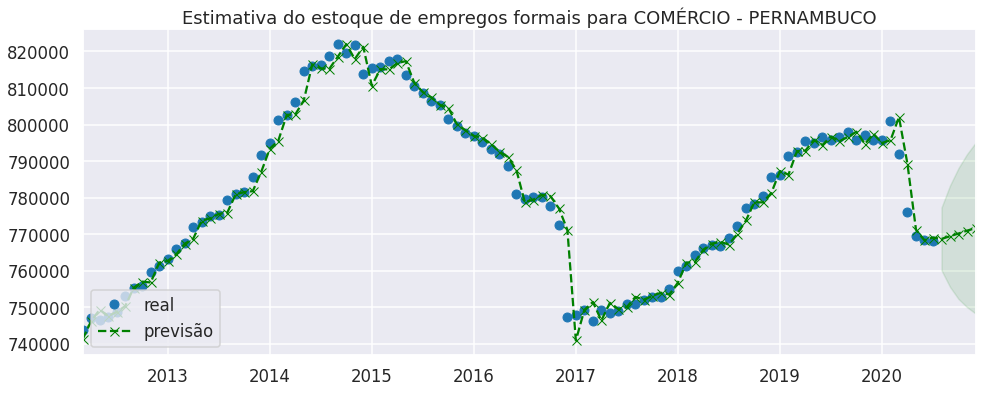

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))
previsoes_sarimax.estoques.loc['2012-03-01':].plot(ax=ax, style='o', label='real')

previsoes_sarimax.fcast.loc['2012-03-01':].plot(ax=ax, style='g--x', label='previsão')

ax.fill_between(
    previsoes_sarimax.index, 
    previsoes_sarimax.iloc[:,2], 
    previsoes_sarimax.iloc[:,3], color='g', alpha=0.1)

plt.title('Estimativa do estoque de empregos formais para COMÉRCIO - PERNAMBUCO')
legend = ax.legend(loc='lower left')

Até o fim do ano o saldo será:

In [31]:
fcast_sarimax.predicted_mean[-1] - df.estoques[-1]

3512.8291400322923

In [32]:
pred2020df = pd.DataFrame(df_saldo.saldo[-1] + fcast_sarimax.predicted_mean[-1] - df.estoques[-1], 
                          index=["2020"], columns=['saldo'])
pred2020df.index.name = "Ano"
pred2020df.index = pd.to_datetime(pred2020df.index, format="%Y")

# df_saldo.update(pred2020df)
# df_saldo.tail()

In [33]:
df_saldo_pred = pd.concat([df_saldo[1:][:-1], pred2020df], axis=0)
df_saldo_pred

,saldo
2011-01-01,30130.00000
2012-01-01,24953.00000
2013-01-01,21847.00000
2014-01-01,23119.00000
2015-01-01,-19848.00000
2016-01-01,-30707.00000
2017-01-01,2723.00000
2018-01-01,22918.00000
2019-01-01,10016.00000
2020-01-01,-23974.17086


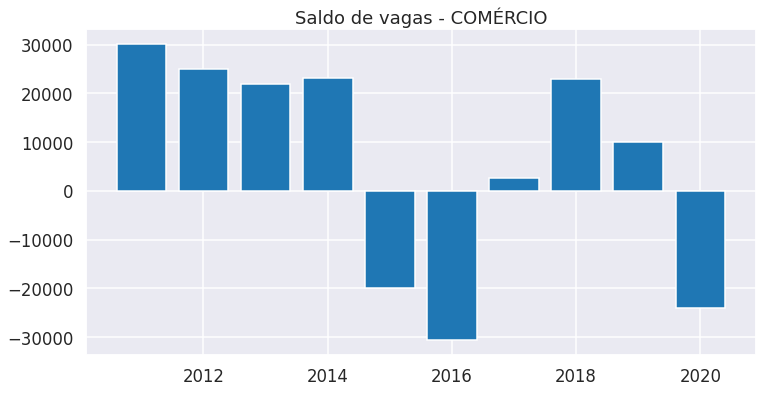

In [34]:
plt.figure(figsize=(12, 6))
plt.bar(df_saldo_pred.index.year, df_saldo_pred.saldo)
plt.title('Saldo de vagas - COMÉRCIO')
plt.show();